# 함수화한 모델

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings(action = 'ignore')

## 1. 데이터 로드 및 전처리

### 1.1. 데이터 로드

In [34]:
tmp_df = pd.read_csv('../data/행정동_기준_동별데이터_버스추가.csv')
pd.set_option('display.max_columns',25)
tmp_df.rename(columns={'Unnamed: 0':'index'},inplace=True)
tmp_df.set_index('index',inplace=True)

In [35]:
tmp_df = tmp_df[['GU','DONG','DONG_CODE','SUBWAY_NUM','BUS_CNT','STARBUCKS_NUM','SPORT_NUM','SAFE_DLVR_NUM','MC_NUM','KINDER_NUM','KIDS_NUM','GYM_NUM','GOLF_NUM','ACADEMY_NUM','ANIMAL_HSPT_NUM','BIKE_NUM','CAFE','CAR_SHR_NUM','CCTV_NUM','CHILD_MED_NUM', 'CON_NUM', 'DPTM_NUM']]
col = tmp_df.columns[3:]
data = tmp_df[col].values
tmp_df

,GU,DONG,DONG_CODE,SUBWAY_NUM,BUS_CNT,STARBUCKS_NUM,SPORT_NUM,SAFE_DLVR_NUM,MC_NUM,KINDER_NUM,KIDS_NUM,GYM_NUM,GOLF_NUM,ACADEMY_NUM,ANIMAL_HSPT_NUM,BIKE_NUM,CAFE,CAR_SHR_NUM,CCTV_NUM,CHILD_MED_NUM,CON_NUM,DPTM_NUM
index,,,,,,,,,,,,,,,,,,,,,,
0,종로구,청운효자동,1111051500,0.333333,14.0,0.333333,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.000000,18.000000,4.000000,5.666667,39.666667,1.000000,56.666667,7.333333,2.000000,0.0
1,종로구,사직동,1111053000,1.333333,16.0,7.333333,0.0,0.000000,0.0,10.000000,0.000000,18.0,3.000000,19.000000,2.000000,11.666667,100.666667,5.000000,41.666667,10.333333,10.000000,0.0
2,종로구,삼청동,1111054000,0.000000,11.0,1.000000,1.0,0.000000,0.0,10.000000,0.000000,3.0,0.000000,2.000000,0.000000,7.000000,52.000000,1.000000,22.000000,1.000000,1.000000,0.0
3,종로구,부암동,1111055000,0.000000,9.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,2.0,2.000000,24.000000,6.000000,5.000000,30.000000,5.000000,41.000000,5.000000,4.000000,0.0
4,종로구,평창동,1111056000,0.000000,37.0,1.000000,0.0,0.000000,0.0,0.000000,0.000000,5.0,5.000000,28.000000,0.000000,7.000000,36.000000,0.000000,21.000000,10.000000,3.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,강동구,성내2동,1174065000,1.333333,11.0,1.333333,0.0,0.666667,0.0,16.666667,0.666667,10.0,4.666667,63.333333,5.333333,6.000000,47.666667,6.666667,52.000000,4.000000,19.333333,0.0
422,강동구,성내3동,1174066000,1.333333,9.0,1.333333,0.0,0.666667,0.0,16.666667,0.666667,10.0,4.666667,63.333333,5.333333,6.000000,47.666667,6.666667,52.000000,4.000000,19.333333,0.0
423,강동구,길동,1174068500,0.000000,28.0,2.000000,0.0,1.000000,0.0,20.000000,1.000000,18.0,9.000000,100.000000,16.000000,9.000000,63.000000,10.000000,119.000000,10.000000,38.000000,0.0


### 1.2 유저 데이터 입력 및 스케일링

In [5]:
user = [6,1,8,4,8,1,0,1,0,1,1,0,1,1]
# user1 = [8,1,6,9,6,0,0,1,0,0,0,1,0,1]

In [6]:
def user_transform(user): # min_Max Scaling 함수
    user_min = min(user)
    user_max = max(user)
    
    user_scaled = []
    for u in user:
        x = (u - user_min) / (user_max - user_min)
        user_scaled.append(x)
    return user_scaled

In [7]:
user_scaled = user_transform(user)

### 1.3 가중치 matrix

In [8]:
# 임시 가중치 matrix 생성
weight = [[1,0,0,0,0,0,0.2,0.2,0,0,0,0.5,0,0.3],
          [0,1,0.3,0,0,0,0.7,0,0,0,0,0,0.1,0],
          [0,0,1,0,0,0,0.3,0,0,0,0,0,0,0],
          [0,0,0,1,0,0,0,0,0.2,0,0,0.1,0,0],
          [0,0,0,0,1,0,0,0,0,0,0.6,0,0,0],
          [0,0,0,0,0,1,0,0,0,0,0,0,0,0],
          [0,0,0.6,0,0,0,1,0,0.3,0,0,0,0,0],
          [0,0.2,0,0,0,0,0,1,0,0,0,0.7,0,0],
          [0,0,0,0,0,0,0,0,1,0,0,0.4,0,0],
          [0,0,0,0.3,0,0,0,0,0,1,0,0.2,0,0],
          [0,0,0,0,0.5,0,0,0,0,0,1,0,0,0],
          [0,0,0,0.8,0,0.3,0,0,0,0,0,1,0,0],
          [0,0,0,0,0.6,0,0,0,0.2,0,0,0,1,0],
          [0,0,0.3,0,0,0,0,0.6,0,0,0,0,0,1]]

## 2. 군집화

### 2.1 군집화 및 분류 결과 확인

In [37]:
kmeans = KMeans(n_clusters=3, init='k-means++',max_iter=300,random_state=0)
kmeans.fit(data)

KMeans(n_clusters=3, random_state=0)

In [38]:
kmeans.labels_
df = tmp_df.copy()
df['km_cluster'] = kmeans.labels_
df.groupby('km_cluster').count()

,GU,DONG,DONG_CODE,SUBWAY_NUM,BUS_CNT,STARBUCKS_NUM,SPORT_NUM,SAFE_DLVR_NUM,MC_NUM,KINDER_NUM,KIDS_NUM,GYM_NUM,GOLF_NUM,ACADEMY_NUM,ANIMAL_HSPT_NUM,BIKE_NUM,CAFE,CAR_SHR_NUM,CCTV_NUM,CHILD_MED_NUM,CON_NUM,DPTM_NUM
km_cluster,,,,,,,,,,,,,,,,,,,,,,
0,292,292,292,292,292,292,292,292,292,292,292,292,292,292,292,292,292,292,292,292,292,292
1,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40
2,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94


In [39]:
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(data)
df['pca_x']=pca_transformed[:,0]
df['pca_y']=pca_transformed[:,1]

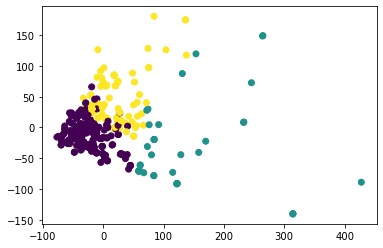

In [40]:
plt.scatter(x=df.loc[:,'pca_x'], y=df.loc[:,'pca_y'],c=df['km_cluster'])

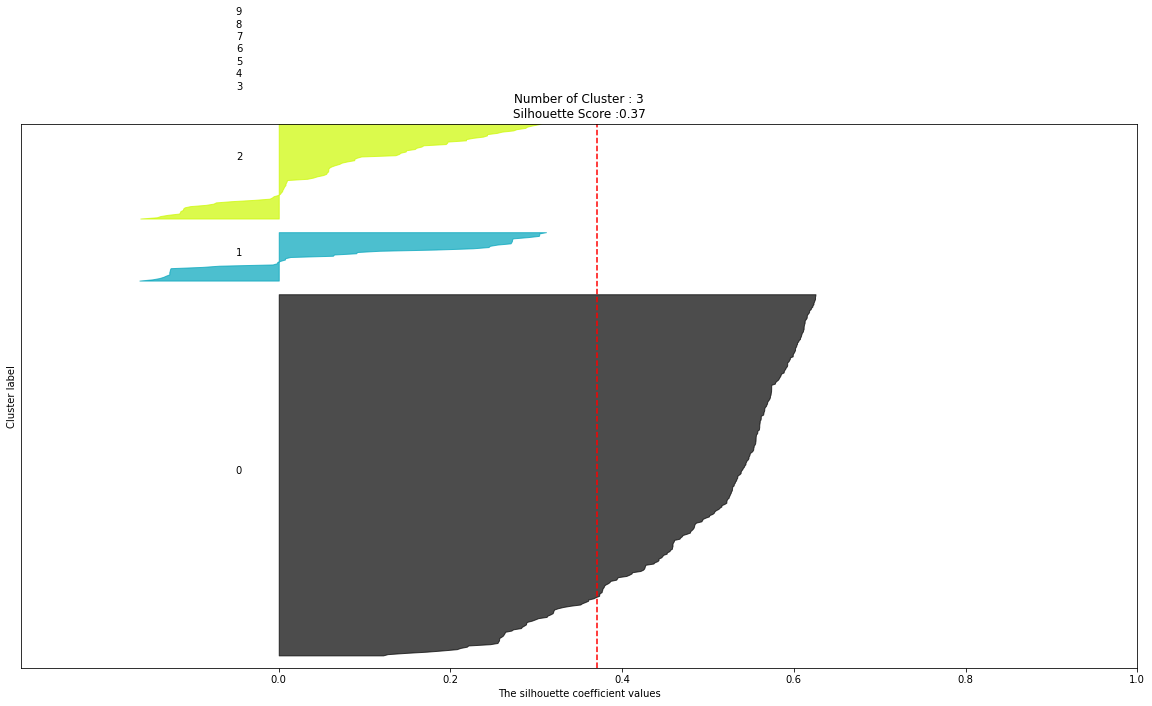

In [41]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math

X_features = data
cluster = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0)
cluster_labels = cluster.fit_predict(data)
sil_avg = silhouette_score(X_features,cluster_labels)
sil_values = silhouette_samples(X_features,cluster_labels)

y_lower = 10
fig, axs = plt.subplots(figsize=(20, 10), nrows=1, ncols=1)

axs.set_title('Number of Cluster : '+ str(3)+'\n' \
                  'Silhouette Score :' + str(round(sil_avg,3)) )
axs.set_xlabel("The silhouette coefficient values")
axs.set_ylabel("Cluster label")
axs.set_xlim([-0.3, 1])
axs.set_ylim([0, len(X_features) + (3 + 1) * 3])
axs.set_yticks([])  # Clear the yaxis labels / ticks
axs.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

for i in range(10):
    ith_cluster_sil_values = sil_values[cluster_labels==i]
    ith_cluster_sil_values.sort()

    size_cluster_i = ith_cluster_sil_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / 3)
    axs.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                        facecolor=color, edgecolor=color, alpha=0.7)
    axs.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

axs.axvline(x=sil_avg, color="red", linestyle="--")

### 2.2 사용자 분류

In [18]:
def user(user_scaled,user_name):
    user_df = pd.DataFrame(columns=col,index=[user_name])
    user_df.loc[user_name] = user_scaled
    cluster_user = kmeans.predict(user_df)
    user_df['km_cluster'] = cluster_user
    return user_df

In [19]:
user_df = user(user_scaled,'user')
user_df

,A,B,C,D,E,a,b,c,d,e,f,g,h,i,km_cluster
user,0.75,0.125,1.0,0.5,1.0,0.125,0.0,0.125,0.0,0.125,0.125,0.0,0.125,0.125,1


In [20]:
# 유저의 군집에 해당하는 지역 추출 함수
def recommand_area(df, user_df, user_name): # 지역 데이터, 유저 데이터, 유저 이름
    rc_area = user_df['km_cluster'].loc[user_name] # 해당 유저의 군집
    rc_seoul = df[df['km_cluster'] == rc_area] # 서울시 내 군집 지역 추출
    rc_list = rc_seoul.index.tolist() # 추천 리스트
    return rc_seoul, rc_list

In [21]:
rc_seoul = recommand_area(df,user_df,'user')[0]
rc_list = recommand_area(df,user_df,'user')[1] 

In [22]:
rc_list # 'user'가 해당하는 군집에 속한 서울 동 리스트

['삼청동',
 '혜화동',
 '명동',
 '필동',
 '약수동',
 '동화동',
 '이태원2동',
 '원효로1동',
 '성수1가2동',
 '능동',
 '청량리동',
 '중화2동',
 '면목3.8동',
 '인수동',
 '창3동',
 '도봉2동',
 '월계2동',
 '중계1동',
 '녹번동',
 '대조동',
 '응암2동',
 '천연동',
 '홍제3동',
 '남가좌1동',
 '용강동',
 '대흥동',
 '아현동',
 '신월3동',
 '신월6동',
 '등촌1동',
 '공항동',
 '방화1동',
 '구로2동',
 '개봉2동',
 '가리봉동',
 '당산2동',
 '신길3동',
 '신길5동',
 '신길6동',
 '대림3동',
 '영등포본동',
 '상도4동',
 '신대방2동',
 '사당2동',
 '청림동',
 '낙성대동',
 '중앙동',
 '조원동',
 '내곡동',
 '대치4동',
 '도곡2동',
 '일원본동',
 '압구정동',
 '청담동',
 '오륜동',
 '장지동',
 '잠실3동',
 '잠실4동',
 '길동',
 '강일동',
 '암사2동',
 '성내2동']

### 2.3 유사도 측정

In [39]:
def similarity(user_df, df, user_name, num): # 유저 데이터, 유사도 측정을 위한 데이터, 유저 이름, 원하는 순위
    con_data = pd.concat([user_df.loc[[user_name]],df])
    rc_sim = cosine_similarity(con_data,con_data)
    sim_matrix = pd.DataFrame(rc_sim,columns=con_data.index).loc[[0]].T
    rank = sim_matrix[0].sort_values(ascending=False) # 유사도 순서로 정렬
    ranking = rank[1:num+1].index.tolist() # 1~n 위 리스트
    return ranking

In [42]:
ranking = similarity(user_df,df,'user',4)
cluster_rank = similarity(user_df,rc_seoul,'user',4)

**겹치는 지역 제거**

In [81]:
def concat_df(rank_1,rank_2): # 두 집단 병합 및 겹침 제거 함수
    tmp_1 = df.loc[rank_1]
    tmp_2 = df.loc[rank_2]
    x = pd.concat([tmp_1,tmp_2])
    x.reset_index(inplace=True)
    x = x.drop_duplicates(['동이름'])
    x.loc[:4]
    x.set_index('동이름',inplace=True)
    del(x['km_cluster'])
    return x

In [82]:
con_df = concat_df(ranking,cluster_rank)
con_df

,A,B,C,D,E,a,b,c,d,e,f,g,h,i
동이름,,,,,,,,,,,,,,
청림동,0.9,0.2,0.9,0.7,0.9,0.5,0.4,0.4,0.4,0.6,0.4,0.3,0.1,0.8
개봉2동,1.0,0.3,1.0,0.7,0.8,0.7,0.1,0.3,0.8,0.3,0.3,0.4,0.3,0.4
대치4동,0.6,0.5,0.5,0.2,1.0,0.2,0.5,0.2,0.1,0.6,0.1,0.2,0.2,0.1
월계2동,0.9,0.1,1.0,0.1,0.8,0.5,0.1,0.4,0.3,0.6,0.9,0.5,0.3,0.2


In [90]:
def weighting(df, weight): # 가중치 부여 된 데이터 프레임 생성 함수
    data = df.values
    w = [0] * 14
    for i in range(len(weight)):
        if(user_df.loc['user'][i] != 0):
            for k in range(len(weight)):
                w[i] += weight[i][k]
    modified = []
    for k in range(len(data)):
        modi = []
        for i in range(len(w)):
            mod = data[k][i] * (1 + w[i])
            modi.append(mod)
        modified.append(modi)
    weighted_df = pd.DataFrame(modified,index=df.index,columns=col)
    return weighted_df

In [107]:
weighted_df = weighting(con_df,weight)
weighted_df

,A,B,C,D,E,a,b,c,d,e,f,g,h,i
동이름,,,,,,,,,,,,,,
청림동,2.88,0.62,2.07,1.61,2.34,1.0,0.4,1.16,0.4,1.50,1.00,0.3,0.28,2.32
개봉2동,3.20,0.93,2.30,1.61,2.08,1.4,0.1,0.87,0.8,0.75,0.75,0.4,0.84,1.16
대치4동,1.92,1.55,1.15,0.46,2.60,0.4,0.5,0.58,0.1,1.50,0.25,0.2,0.56,0.29
월계2동,2.88,0.31,2.30,0.23,2.08,1.0,0.1,1.16,0.3,1.50,2.25,0.5,0.84,0.58


In [133]:
def ranking(weighted_df): # 가중치 데이터 프레임으로 3위까지
    sums = []
    for i in range(len(weighted_df.index)):
        sums.append(weighted_df.iloc[i].sum())
    weighted_df['sum'] = sums
    oh = weighted_df.T.loc['sum'].sort_values(ascending=False)
    x = pd.DataFrame(oh).index.tolist()[0:3]
    return x

In [135]:
x = ranking(weighted_df)
x

['청림동', '개봉2동', '월계2동']